## Imports

In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
# using Piccolo
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
# using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random
using NamedTrajectories

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651


In [3]:
# Problem parameters
T = 40
Δt = 0.8
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)
seeds = rand(1:1000, 25)
F=0.9999
num_iter = 6000
hess = false
hess_iter = 120
Qs = 10 .^ range(-4.0, 1.0, length=25)
a_bound = 1.0
dda_bound = 0.5
R=5e-3


0.005

In [30]:
Qs

25-element Vector{Float64}:
  0.0001
  0.00016155980984398745
  0.0002610157215682536
  0.00042169650342858224
  0.0006812920690579615
  0.0011006941712522092
  0.0017782794100389228
  0.0028729848333536655
  0.004641588833612777
  0.007498942093324558
  ⋮
  0.2154434690031884
  0.3480700588428411
  0.5623413251903491
  0.9085175756516868
  1.4677992676220695
  2.371373705661655
  3.831186849557288
  6.189658188912605
 10.0

In [11]:
# Adjoint, rollout initialization

∂ₑHₐ = [PAULIS.Z]
varsys_add = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)
n_seeds = length(seeds)
nQ = length(Qs)
var_probs = Matrix{Any}(undef, n_seeds, nQ)
# var_probs = Matrix{Any}(undef, n_seeds, nQ)

var_count = length(varsys_add.G_vars)

for (i, seed) in enumerate(seeds)
    Random.seed!(seed)
    for (j, Q) in enumerate(Qs)

        var_count = length(varsys_add.G_vars)

        var_prob = UnitaryVariationalProblem(
            varsys_add, U_goal, T, Δt;
            robust_times = [[T] for _ in 1:var_count],
            a_bound=a_bound, 
            dda_bound=dda_bound,
            Δt_max=Δt,
            Δt_min=Δt,
            Q=0.0,
            Q_r = 1.0,   # > 0
            Q_s = 0.0,     # (irrelevant since sensitive_times is empty)
            piccolo_options = PiccoloOptions(verbose=false)
        )

        # Initialize with a rollout, not the geodesic
        init_traj = deepcopy(var_prob.trajectory)
        init_traj.Ũ⃗ .= unitary_rollout(init_traj, varsys_add)

        var_prob = UnitaryVariationalProblem(
                varsys_add, U_goal, T, Δt;
                robust_times = [[T] for _ in 1:var_count],
                a_bound=a_bound, 
                dda_bound=dda_bound,
                Δt_max=Δt,
                Δt_min=Δt,
                Q=0.0,
                Q_r = Q,
                Q_s = 0.0,
                R=R,
                piccolo_options = PiccoloOptions(verbose=false)
            )
        push!(
            var_prob.constraints, 
            FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory)
        );
        solve!(var_prob, max_iter=num_iter, print_level=0, options=IpoptOptions(eval_hessian=false))
        solve!(var_prob, max_iter=hess_iter, print_level=0)
        var_probs[i,j] = var_prob
    end
end

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
      

Excessive output truncated after 524317 bytes.

    initializing optimizer...
        applying constraint: timesteps all equal constraint

In [4]:
var_prob[1].trajectory.Δt[1], var_prob[1].trajectory.Δt[end ÷ 2]

UndefVarError: UndefVarError: `var_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [5]:
∂ₑH = [PAULIS.Z]
H_drives = [PAULIS.X, PAULIS.Y, PAULIS.Z]
error_ops = [PAULIS.Z]

function var_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}}, 
    H_errors::Vector{Matrix{ComplexF64}}
)
    Δt = traj.Δt[1]
    varsys = VariationalQuantumSystem(H_drives, H_errors)
    Ũ⃗, ∂Ũ⃗ = variational_unitary_rollout(traj, varsys)

    U = iso_vec_to_operator(Ũ⃗[:, end])
    # First error term
    ∂U = iso_vec_to_operator(∂Ũ⃗[1][:, end])

    d = size(U, 1)
    return abs(tr((U'*∂U)'*(U'*∂U))) / (T * Δt)^2 / d
end

# J_var = var_obj(var_prob.trajectory, H_drives, error_ops)

var_obj (generic function with 1 method)

In [12]:
function tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64}
)
    T = traj.T
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(traj, sys)))
    
    # Toggle integral
    H_ti = sum(Δt[i] .* U[i]' * H_error * U[i] for i=1:T-1)

    d₁ = size(U[1], 1)
    Δt₁ = Δt[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end


tog_obj (generic function with 1 method)

In [14]:
J_tog / J_var

8.546746224338484

In [7]:
function commutator(A::AbstractMatrix{<:Number}, B::AbstractMatrix{<:Number})
    return A*B - B*A
end

commutator (generic function with 1 method)

In [13]:
function pert_tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64};
    order::Int=1,
    a_bound::Float64=a_bound
)
    T = traj.T
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(traj, sys)))

    # toggle integral
    H_ti = zeros(ComplexF64, size(U[1]))

    # note: U_1 = I, so U[:, k] = U_{k-1}.
    # you need to go to T-1, only
    for k in 1:T-1
        Hₖ = sum(traj.a[l, k] / a_bound * H for (l, H) in enumerate(H_drives))
        adjⁿH_E = H_error
        Eₖ_n = H_error * Δt[k]
        
        # get the different orders of the Hadamard lemma
        for n in 2:order
            coef_n = ComplexF64(im^(n-1) * a_bound^(n-1) * Δt[k]^n / factorial(big(n)))
            adjⁿH_E = commutator(Hₖ, adjⁿH_E)
            # Eₖ_n = push!(Eₖ_n, coef_n * adjⁿH_E)
            Eₖ_n += coef_n * adjⁿH_E
        end

        # nth order toggle integral up to k
        H_ti += U[k]' * Eₖ_n * U[k]
    end

    d₁ = size(U[1], 1)
    Δt₁ = Δt[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end

pert_tog_obj (generic function with 1 method)

In [17]:
pert_tog_obj(var_prob.trajectory, H_drives, PAULIS.Z, order=1)

0.00033492546876706046

In [18]:
pert_tog_obj(var_prob.trajectory, H_drives, PAULIS.Z, order=5)

3.9187303149719265e-5

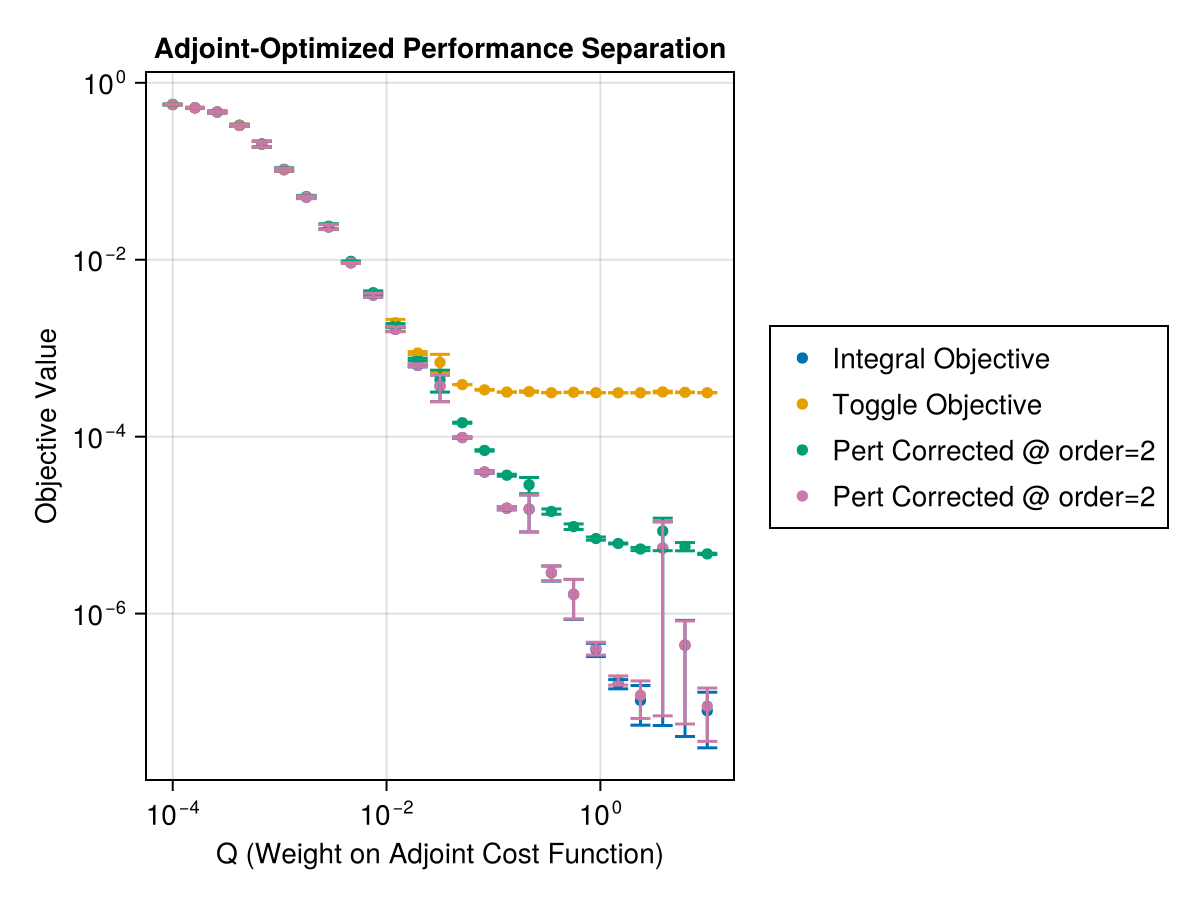

In [ ]:
# Initialize arrays for means and errors
tog_objs = []
tog_vars = []
tog_pert1 = []
tog_pert2 = []

tog_objs_std = []
tog_vars_std = []
tog_pert1_std = []
tog_pert2_std = []

tog_objs_sem = []  # Standard error of the mean
tog_vars_sem = []
tog_pert1_sem = []
tog_pert2_sem = []

for (j, Q) in enumerate(Qs)
    # Collect all values for this Q across seeds
    objs_at_Q = [tog_obj(var_probs[i,j].trajectory, H_drives, error_ops[1]) for i in 1:n_seeds]
    vars_at_Q = [var_obj(var_probs[i,j].trajectory, H_drives, error_ops) for i in 1:n_seeds]
    pert1_at_Q = [pert_tog_obj(var_probs[i,j].trajectory, H_drives, PAULIS.Z, order=2) for i in 1:n_seeds]
    pert2_at_Q = [pert_tog_obj(var_probs[i,j].trajectory, H_drives, PAULIS.Z, order=3) for i in 1:n_seeds]

    # Compute means
    push!(tog_objs, mean(objs_at_Q))
    push!(tog_vars, mean(vars_at_Q))
    push!(tog_pert1, mean(pert1_at_Q))
    push!(tog_pert2, mean(pert2_at_Q))

    # Compute standard deviations
    push!(tog_objs_std, std(objs_at_Q))
    push!(tog_vars_std, std(vars_at_Q))
    push!(tog_pert1_std, std(pert1_at_Q))
    push!(tog_pert2_std, std(pert2_at_Q))

    # Compute standard error of the mean (std / sqrt(n))
    push!(tog_objs_sem, std(objs_at_Q) / sqrt(n_seeds))
    push!(tog_vars_sem, std(vars_at_Q) / sqrt(n_seeds))
    push!(tog_pert1_sem, std(pert1_at_Q) / sqrt(n_seeds))
    # push!(tog_pert2_sem, std(pert2_at_Q) / sqrt(n_seeds))

end


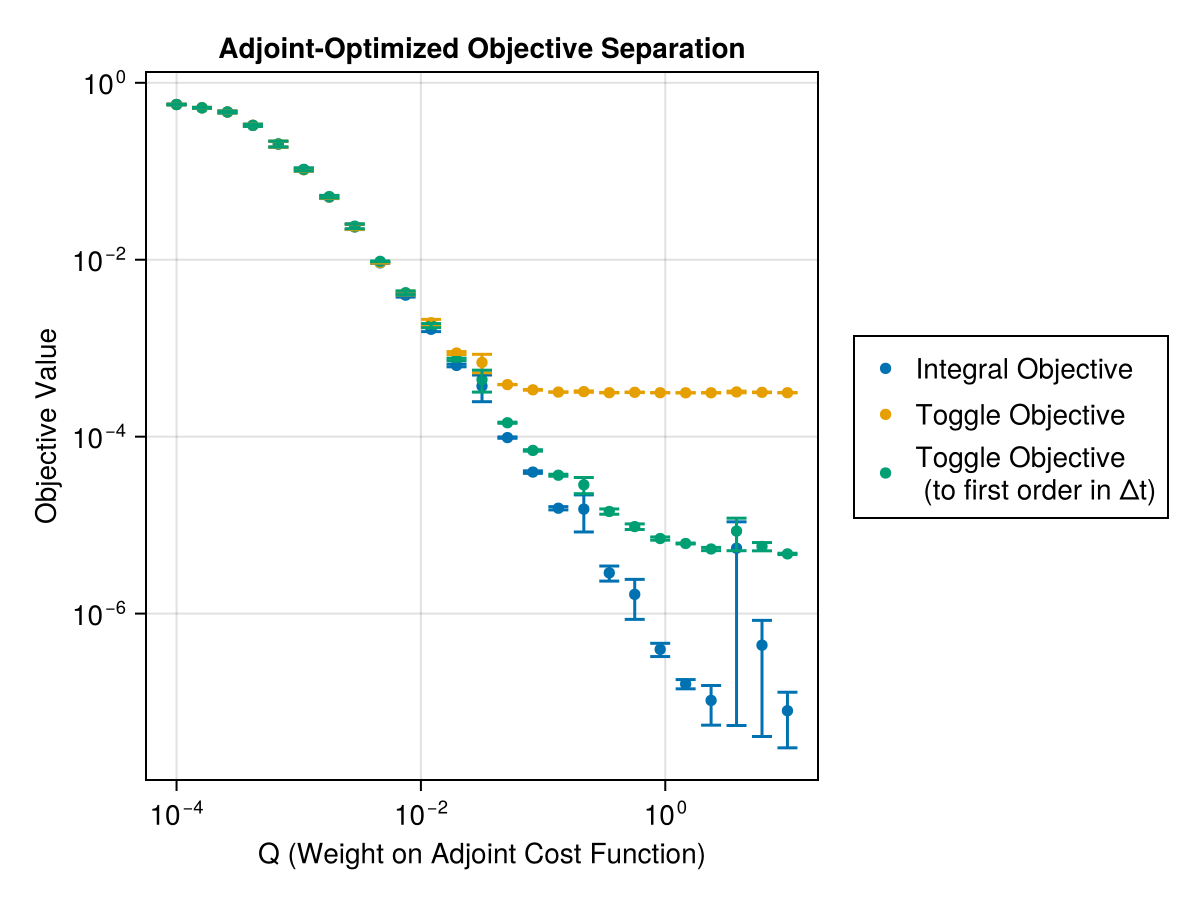

In [31]:

# Plot with error bars (using standard error)
fig = Figure()# "T=$T, Δt=$Δt, a=$a_bound, dda=$dda_bound, R=$R"
ax = Axis(fig[1, 1], title="Adjoint-Optimized Objective Separation",
          xlabel="Q (Weight on Adjoint Cost Function)", ylabel="Objective Value", xscale=log10, yscale=log10)

scatter!(ax, Qs, tog_vars; label="Integral Objective", markersize=8)
scatter!(ax, Qs, tog_objs; label="Toggle Objective", markersize=8)
scatter!(ax, Qs, tog_pert1; label="Toggle Objective \n (to first order in Δt)", markersize=8)
# scatter!(ax, Qs, tog_pert2; label="Pert Corrected @ order=2", markersize=8)

errorbars!(ax, Qs, tog_vars, tog_vars_sem; whiskerwidth=10)
errorbars!(ax, Qs, tog_objs, tog_objs_sem; whiskerwidth=10)
errorbars!(ax, Qs, tog_pert1, tog_pert1_sem; whiskerwidth=10)
# errorbars!(ax, Qs, tog_pert2, tog_pert2_sem; whiskerwidth=10)

Legend(fig[1,2], ax)

fig

In [16]:
using JLD2, FileIO

# Create the directory
artifacts_dir = "artifacts/var_gap_data"
mkpath(artifacts_dir)

# Save the var_probs data and parameters
save(joinpath(artifacts_dir, "var_probs.jld2"), Dict(
    "var_probs" => var_probs,
    "seeds" => seeds,
    "Qs" => Qs,
    "F" => F,
    "num_iter" => num_iter,
    "hess_iter" => hess_iter,
    "a_bound" => a_bound,
    "dda_bound" => dda_bound,
    "R" => R
))

# Save the figure
save(joinpath(artifacts_dir, "plot.png"), fig)

println("Data saved to $artifacts_dir")


In [17]:
using JLD2, FileIO

# Create the directory
artifacts_dir = "artifacts/var_gap_data_export"
mkpath(artifacts_dir)

# Save var_probs data for each seed in separate files
for (i, seed) in enumerate(seeds)
    save(joinpath(artifacts_dir, "var_probs_seed_idx_$(i).jld2"), Dict(
        "var_probs" => var_probs[i, :],
        "seed" => seed,
        "Qs" => Qs,
        "F" => F,
        "num_iter" => num_iter,
        "hess_iter" => hess_iter,
        "a_bound" => a_bound,
        "dda_bound" => dda_bound,
        "R" => R
    ))
end

# Save the figure
save(joinpath(artifacts_dir, "plot.png"), fig)

println("Data saved to $artifacts_dir")
println("Created $(length(seeds)) separate files, one for each seed")